In [41]:
import json
import os
from pathlib import Path
from typing import List, Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import RandomizedSearchCV
import joblib
from scipy.stats import randint
from scipy.stats import loguniform
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree
import warnings

warnings.filterwarnings('ignore')

In [42]:
# Set up the root path for the project
root_path: Path = Path().resolve().parent

In [43]:
# Load the configuration file
config_path: str = os.path.join(root_path, 'config.json')
with open(config_path, 'r') as config_file:
    config: Dict[str, Any] = json.load(config_file)

In [44]:
# Load the weather data from CSV file
file_path: str = os.path.join(root_path, 'data', 'csv', 'weatherAUS.csv')
df: pd.DataFrame = pd.read_csv(file_path)

In [45]:
# Define column renaming dictionary
column_rename_dict: Dict[str, str] = {
    'Date': 'date',
    'Location': 'location',
    'MinTemp': 'min_temp',
    'MaxTemp': 'max_temp',
    'Rainfall': 'rainfall',
    'Evaporation': 'evaporation',
    'Sunshine': 'sunshine',
    'WindGustDir': 'wind_gust_dir',
    'WindGustSpeed': 'wind_gust_speed',
    'WindDir9am': 'wind_dir_9am',
    'WindDir3pm': 'wind_dir_3pm',
    'WindSpeed9am': 'wind_speed_9am',
    'WindSpeed3pm': 'wind_speed_3pm',
    'Humidity9am': 'humidity_9am',
    'Humidity3pm': 'humidity_3pm',
    'Pressure9am': 'pressure_9am',
    'Pressure3pm': 'pressure_3pm',
    'Cloud9am': 'cloud_9am',
    'Cloud3pm': 'cloud_3pm',
    'Temp9am': 'temp_9am',
    'Temp3pm': 'temp_3pm',
    'RainToday': 'rain_today',
    'RainTomorrow': 'rain_tomorrow'
}

# Rename columns
df = df.rename(columns=column_rename_dict)

In [46]:
# Filter the DataFrame to include only specific locations
locations_of_interest: List[str] = config['locations']
df = df[df['location'].isin(locations_of_interest)]

In [47]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [48]:
# Display the first few rows of the DataFrame
df.head()

,date,location,min_temp,max_temp,rainfall,evaporation,sunshine,wind_gust_dir,wind_gust_speed,wind_dir_9am,...,humidity_9am,humidity_3pm,pressure_9am,pressure_3pm,cloud_9am,cloud_3pm,temp_9am,temp_3pm,rain_today,rain_tomorrow
30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,...,92.0,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes
30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,W,...,83.0,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes
30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,ESE,...,88.0,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes
30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,NNE,...,83.0,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes
30180,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,NNE,...,88.0,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes


In [49]:
# Display the shape of the DataFrame
df.shape

(13166, 23)

In [50]:
# Data Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13166 entries, 30176 to 142303
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             13166 non-null  datetime64[ns]
 1   location         13166 non-null  object        
 2   min_temp         12675 non-null  float64       
 3   max_temp         12679 non-null  float64       
 4   rainfall         12383 non-null  float64       
 5   evaporation      11454 non-null  float64       
 6   sunshine         11230 non-null  float64       
 7   wind_gust_dir    11729 non-null  object        
 8   wind_gust_speed  11735 non-null  float64       
 9   wind_dir_9am     12491 non-null  object        
 10  wind_dir_3pm     12890 non-null  object        
 11  wind_speed_9am   12907 non-null  float64       
 12  wind_speed_3pm   12916 non-null  float64       
 13  humidity_9am     12605 non-null  float64       
 14  humidity_3pm     12652 non-null  

In [51]:
# Descriptive Statistics
df.describe()

,min_temp,max_temp,rainfall,evaporation,sunshine,wind_gust_speed,wind_speed_9am,wind_speed_3pm,humidity_9am,humidity_3pm,pressure_9am,pressure_3pm,cloud_9am,cloud_3pm,temp_9am,temp_3pm
count,12675.000000,12679.000000,12383.000000,11454.000000,11230.000000,11735.000000,12907.000000,12916.000000,12605.000000,12652.000000,12438.000000,12441.000000,10491.000000,10231.000000,12662.000000,12669.000000
mean,14.129799,24.377530,3.057498,5.222368,7.358709,42.038517,14.901294,20.333462,69.480444,50.819712,1016.698392,1014.055276,4.616910,4.595445,18.103514,22.895793
std,7.652003,7.093133,10.590969,2.855495,3.716506,13.522773,9.222554,8.346006,15.171432,17.689511,7.211286,7.242959,2.711051,2.620294,7.349728,7.018754
min,-8.000000,4.100000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,11.000000,4.000000,986.700000,985.500000,0.000000,0.000000,-1.300000,3.700000
25%,8.900000,18.500000,0.000000,3.000000,4.600000,33.000000,9.000000,15.000000,60.000000,39.000000,1011.800000,1008.700000,2.000000,2.000000,12.400000,17.200000
50%,14.000000,24.200000,0.000000,5.000000,8.300000,39.000000,13.000000,20.000000,71.000000,51.000000,1016.000000,1013.100000,5.000000,5.000000,17.700000,22.600000
75%,20.300000,31.200000,1.000000,7.000000,10.500000,50.000000,20.000000,26.000000,80.000000,62.000000,1021.700000,1019.200000,7.000000,7.000000,24.300000,29.400000
max,29.700000,46.400000,367.600000,23.800000,13.900000,126.000000,67.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,36.500000,45.400000


In [52]:
# Missing Values
df.isna().sum()

date                  0
location              0
min_temp            491
max_temp            487
rainfall            783
evaporation        1712
sunshine           1936
wind_gust_dir      1437
wind_gust_speed    1431
wind_dir_9am        675
wind_dir_3pm        276
wind_speed_9am      259
wind_speed_3pm      250
humidity_9am        561
humidity_3pm        514
pressure_9am        728
pressure_3pm        725
cloud_9am          2675
cloud_3pm          2935
temp_9am            504
temp_3pm            497
rain_today          783
rain_tomorrow       784
dtype: int64

In [53]:
# Drop rows with missing target values
df = df.dropna(subset=['rain_today', 'rain_tomorrow'])

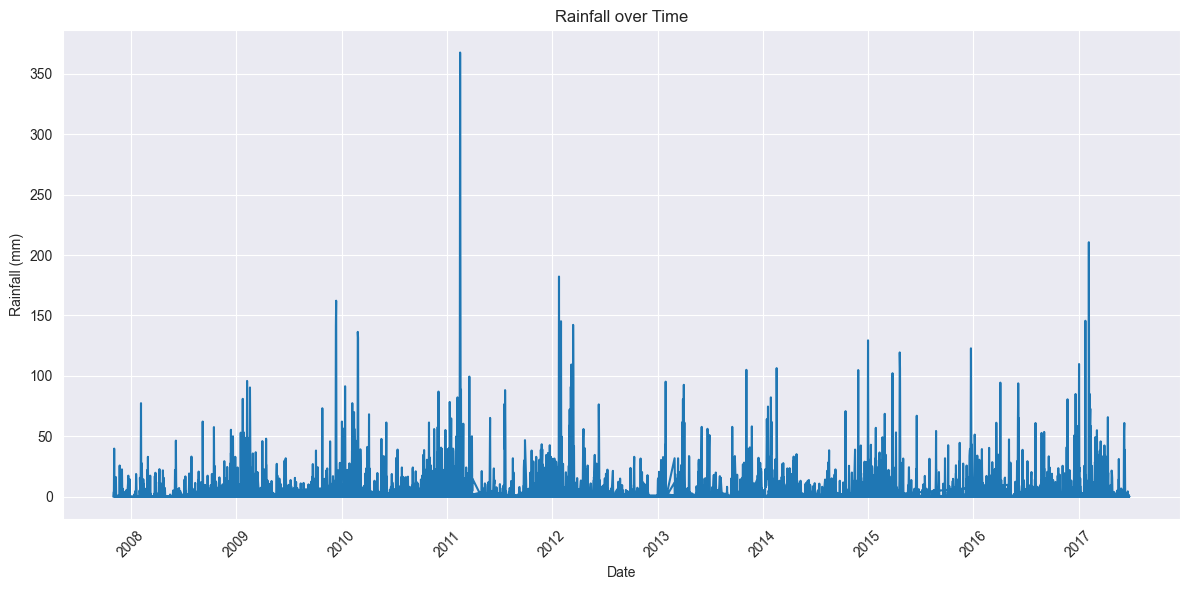

In [54]:
# Rainfall over Time
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['rainfall'])
plt.title('Rainfall over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

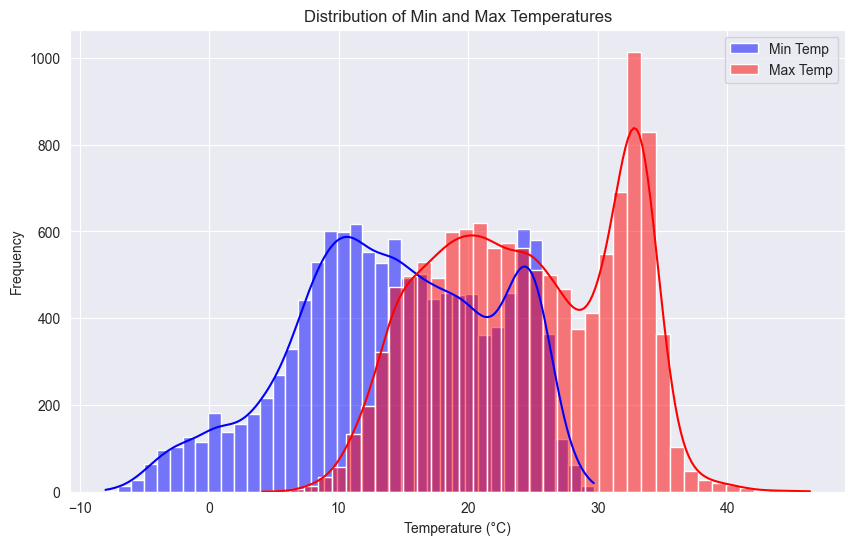

In [55]:
# Distribution of Min and Max Temperatures
plt.figure(figsize=(10, 6))
sns.histplot(df['min_temp'], kde=True, color='blue', alpha=0.5, label='Min Temp')
sns.histplot(df['max_temp'], kde=True, color='red', alpha=0.5, label='Max Temp')
plt.title('Distribution of Min and Max Temperatures')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

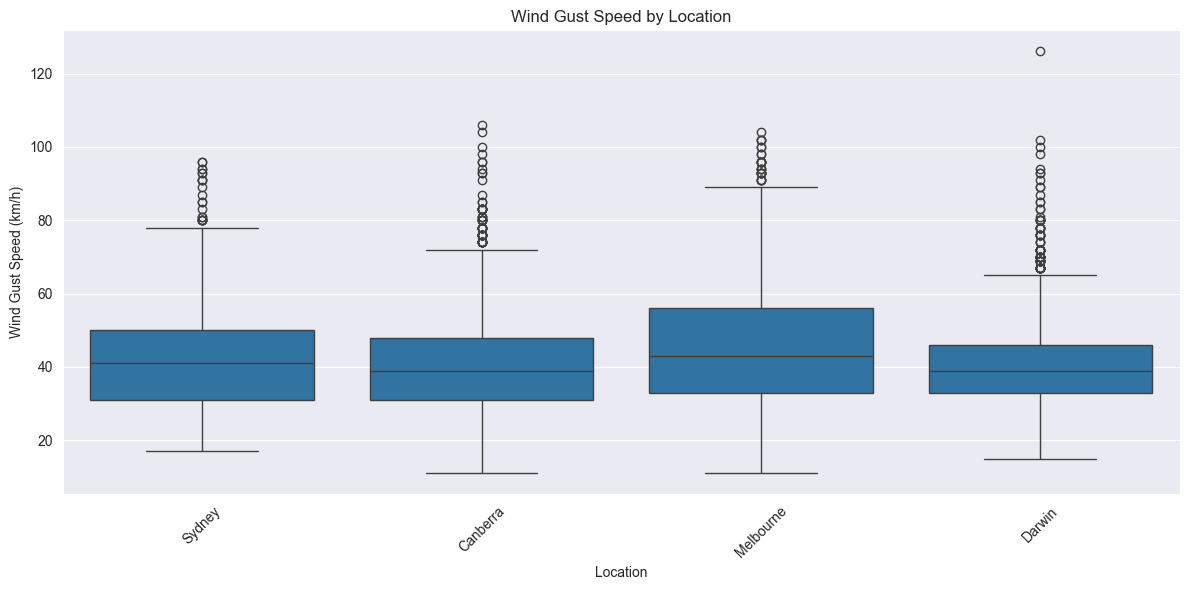

In [56]:
# Wind Gust Speed by Location
plt.figure(figsize=(12, 6))
sns.boxplot(x='location', y='wind_gust_speed', data=df)
plt.title('Wind Gust Speed by Location')
plt.xlabel('Location')
plt.ylabel('Wind Gust Speed (km/h)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

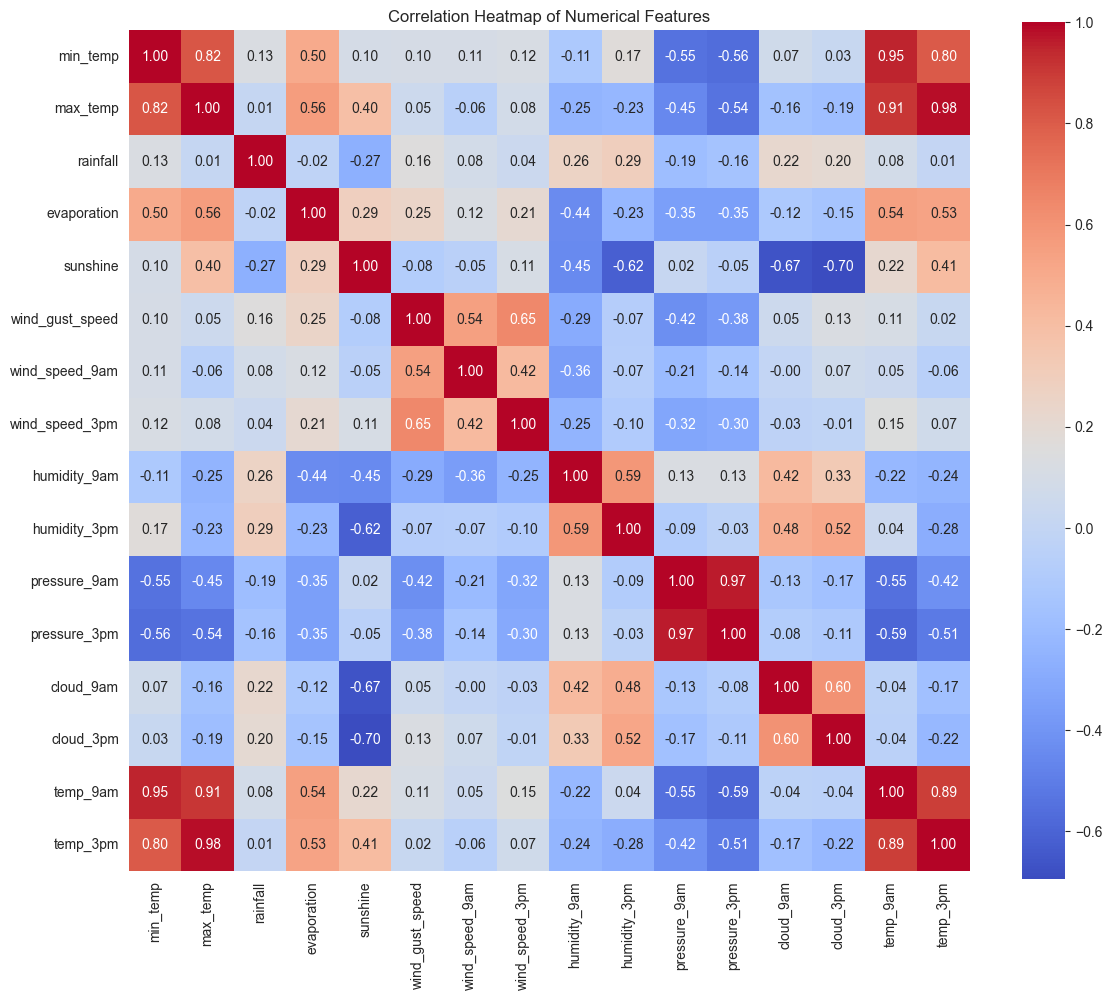

In [57]:
# Correlation Heatmap of Numerical Features
corr = df[df.select_dtypes(include=['int64', 'float64']).columns.tolist()].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

In [58]:
def create_preprocessor(numerical_columns: List[str],
                        categorical_columns: List[str]) -> ColumnTransformer:
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns),
        ])

    return preprocessor

In [59]:
def create_model_pipeline(model: BaseEstimator, preprocessor: ColumnTransformer, 
                          oversample: bool = False) -> ImbPipeline:
    steps = [('preprocessor', preprocessor)]
    
    if oversample:
        steps.append(('sampler', RandomOverSampler(random_state=42)))
    
    steps.append(('model', model))
    
    return ImbPipeline(steps)

In [60]:
def compare_models(models: Dict[str, BaseEstimator], X: pd.DataFrame, y: pd.Series, 
                   preprocessor: ColumnTransformer, 
                   param_grids: Dict[str, Dict[str, Any]],
                   n_iter: int = 10,
                   cv: int = 5) -> Dict[str, Dict[str, Any]]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    results = {}
    
    for name, model in models.items():
        # Without oversampling
        pipeline_no_os = create_model_pipeline(model, preprocessor, oversample=False)
        search_no_os = RandomizedSearchCV(pipeline_no_os, param_grids[name], n_iter=n_iter, cv=cv, n_jobs=-1, random_state=42, scoring='f1')
        search_no_os.fit(X_train, y_train)
        
        # With oversampling
        pipeline_os = create_model_pipeline(model, preprocessor, oversample=True)
        search_os = RandomizedSearchCV(pipeline_os, param_grids[name], n_iter=n_iter, cv=cv, n_jobs=-1, random_state=42, scoring='f1')
        search_os.fit(X_train, y_train)
        
        # Evaluate best models
        results[f"{name}_no oversampling"] = evaluate_model(search_no_os.best_estimator_, X_test, y_test)
        results[f"{name}_with oversampling"] = evaluate_model(search_os.best_estimator_, X_test, y_test)
        
        # Store best parameters
        results[f"{name}_no oversampling"]["best_params"] = search_no_os.best_params_
        results[f"{name}_with oversampling"]["best_params"] = search_os.best_params_
    
    return results

In [61]:
def evaluate_model(model: BaseEstimator, X_test: pd.DataFrame, y_test: np.ndarray) -> Dict[str, float]:
    y_pred = model.predict(X_test)
    
    return {
        'accuracy': model.score(X_test, y_test),
        'precision': classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['precision'],
        'recall': classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['recall'],
        'f1-score': classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
    }

In [62]:
# Prepare data for modeling
X: pd.DataFrame = df.drop(['rain_tomorrow', 'date'], axis=1)
y: pd.Series = df['rain_tomorrow']

In [63]:
# Define column types for preprocessing
numerical_columns: List[str] = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns: List[str] = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [64]:
# Display class distribution
y.value_counts(normalize=True)

No     0.764951
Yes    0.235049
Name: rain_tomorrow, dtype: float64

In [65]:
# Encode target variable
target_le = LabelEncoder()
y = target_le.fit_transform(y)

In [66]:
# Define models to compare
models: Dict[str, BaseEstimator] = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

In [67]:
param_grids = {
    'Logistic Regression': {
        'model__C': loguniform(1e-5, 100),
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs'],
        'model__max_iter': [1000, 2000, 5000]
    },
    'Decision Tree': {
        'model__max_depth': [3, 5, 7, 9, None],
        'model__min_samples_split': randint(2, 20),
        'model__min_samples_leaf': randint(1, 20)
    },
    'Random Forest': {
        'model__n_estimators': randint(10, 200),
        'model__max_depth': [3, 5, 7, 9, None],
        'model__min_samples_split': randint(2, 20),
        'model__min_samples_leaf': randint(1, 20)
    }
}

In [68]:
# Create preprocessor
preprocessor = create_preprocessor(numerical_columns, categorical_columns)

In [69]:
results = compare_models(models, X, y, preprocessor, param_grids, n_iter=20, cv=5)

In [70]:
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        if metric == 'best_params':
            print(f"\tBest parameters: {value}")
        else:
            print(f"\t\t{metric}: {value:.4f}")


Logistic Regression_no oversampling:
		accuracy: 0.8438
		precision: 0.8353
		recall: 0.8438
		f1-score: 0.8359
	Best parameters: {'model__C': 57.46775499181863, 'model__max_iter': 2000, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

Logistic Regression_with oversampling:
		accuracy: 0.7980
		precision: 0.8305
		recall: 0.7980
		f1-score: 0.8078
	Best parameters: {'model__C': 0.006295450333384249, 'model__max_iter': 5000, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

Decision Tree_no oversampling:
		accuracy: 0.8164
		precision: 0.8097
		recall: 0.8164
		f1-score: 0.8123
	Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 19, 'model__min_samples_split': 8}

Decision Tree_with oversampling:
		accuracy: 0.7497
		precision: 0.8118
		recall: 0.7497
		f1-score: 0.7660
	Best parameters: {'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 19}

Random Forest_no oversampling:
		accuracy: 0.8425
		precision: 0.8340
		recall: 0.8425
		f1

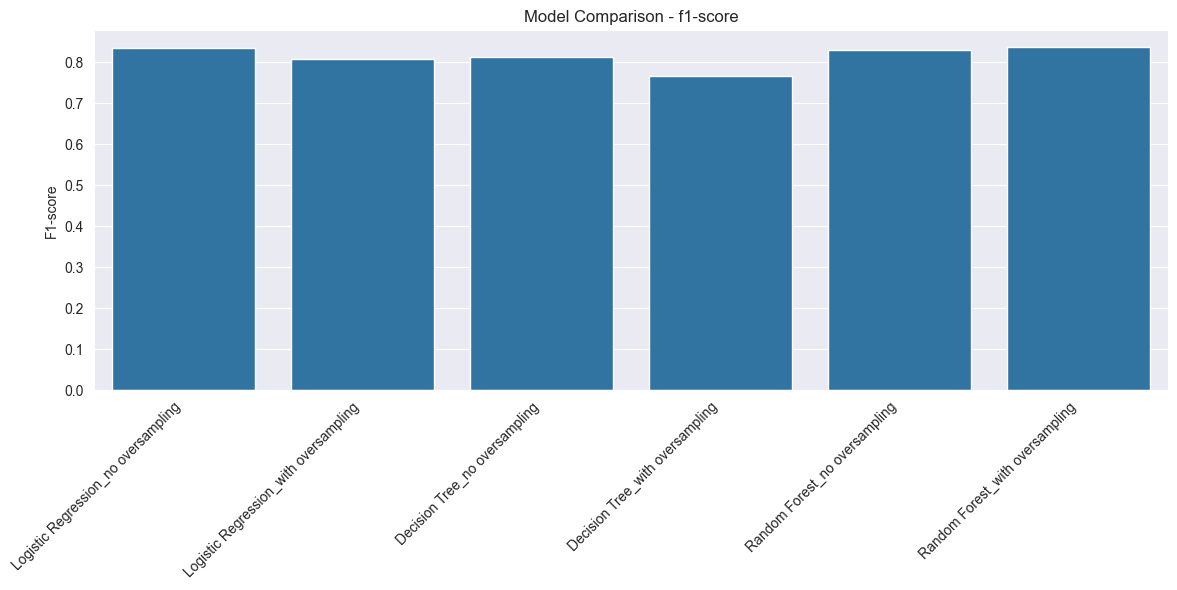

In [71]:
# Visualize model comparison
def plot_model_comparison(results: Dict[str, Dict[str, Any]], metric: str = 'f1-score') -> None:
    models = list(results.keys())
    scores = [results[model][metric] for model in models]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=models, y=scores)
    plt.title(f'Model Comparison - {metric}')
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
plot_model_comparison(results)

In [72]:
best_model_name = max(results, key=lambda x: results[x]['f1-score'])
best_f1_score = results[best_model_name]['f1-score']
best_params = results[best_model_name]['best_params']

print(f"Best overall model: {best_model_name}")
print(f"Best F1-score: {best_f1_score:.4f}")
print(f"Best parameters: {best_params}")

Best overall model: Random Forest_with oversampling
Best F1-score: 0.8363
Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 9, 'model__n_estimators': 161}


In [73]:
def train_best_model(best_model_name: str, X: pd.DataFrame, y: pd.Series) -> BaseEstimator:
    model_class = type(models[best_model_name.split('_')[0]])
    
    cleaned_params = {k.replace('model__', ''): v for k, v in best_params.items()}
    
    best_model = model_class(**cleaned_params)
    
    if 'with oversampling' in best_model_name:
        pipeline = create_model_pipeline(best_model, preprocessor, oversample=True)
    else:
        pipeline = create_model_pipeline(best_model, preprocessor, oversample=False)
    
    pipeline.fit(X, y)
    return pipeline

best_model_name = max(results, key=lambda x: results[x]['f1-score'])
best_params = results[best_model_name]['best_params']
best_model = train_best_model(best_model_name, X, y)

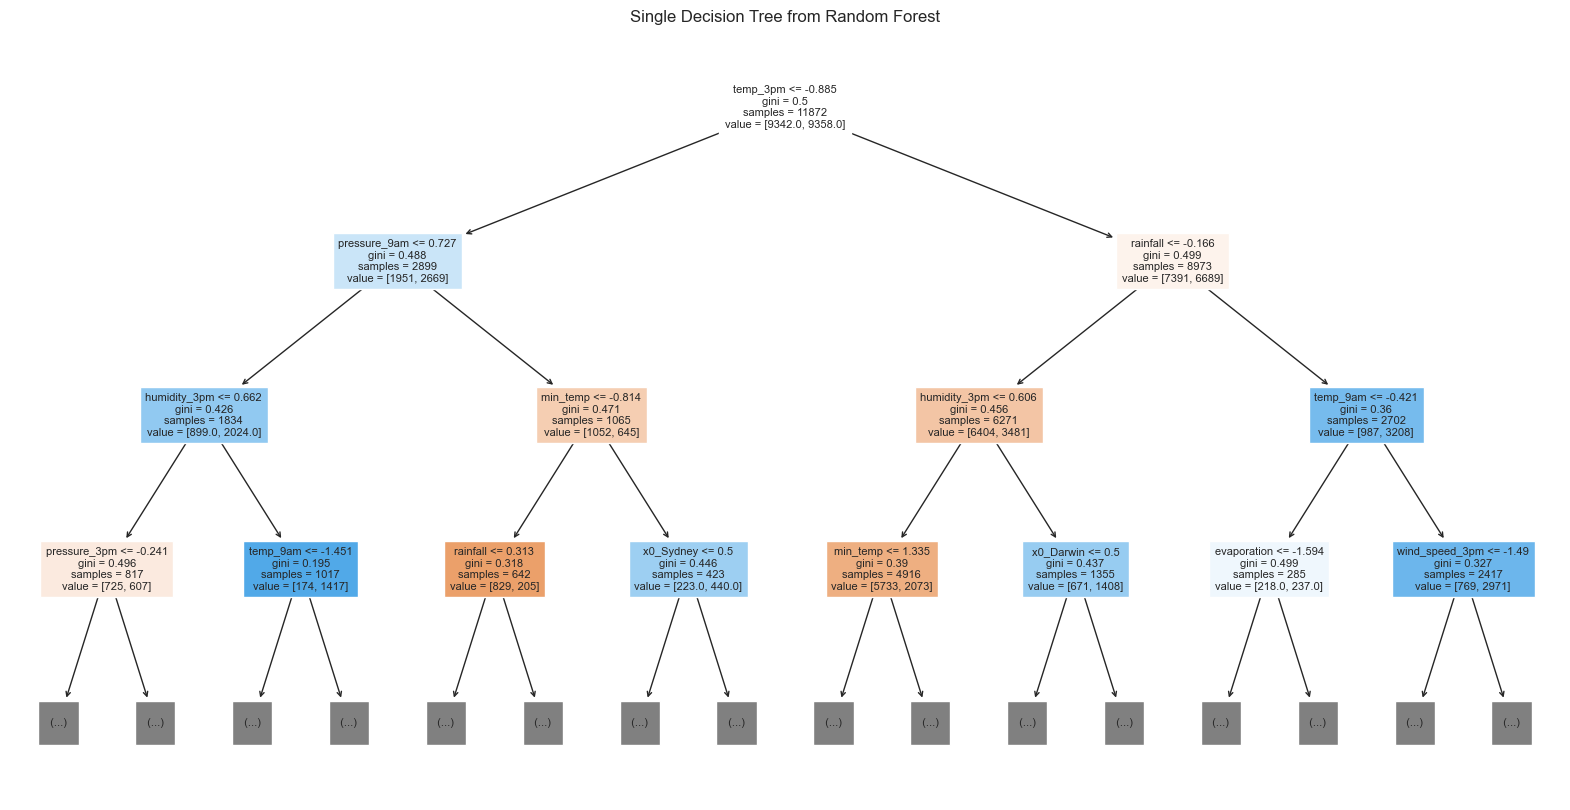

In [74]:
def plot_single_tree_from_forest(model, preprocessor, max_depth=3):
    # Get feature names
    numeric_features = preprocessor.transformers_[0][2]
    categorical_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out().tolist()
    feature_names = numeric_features + categorical_features

    # Select a single tree from the forest (e.g., the first one)
    tree_to_plot = model['model'].estimators_[0]

    plt.figure(figsize=(20, 10))
    plot_tree(tree_to_plot, 
              feature_names=feature_names, 
              filled=True, 
              fontsize=8, 
              max_depth=max_depth)
    plt.title("Single Decision Tree from Random Forest")
    plt.show()

if best_model_name.startswith('Random Forest'):
    plot_single_tree_from_forest(best_model, preprocessor, max_depth=3)

In [75]:
label_filename = os.path.join(root_path, "model", "label_encoder.joblib")
joblib.dump(target_le, label_filename)
print(f"Target label saved to {label_filename}")

model_filename = os.path.join(root_path, "model", "weather_model.joblib")
joblib.dump(best_model, model_filename)
print(f"Best model saved to {model_filename}")

Target label saved to /Users/tanguyboulard/Programmation/DataScientest-project-DEC23/model/label_encoder.joblib
Best model saved to /Users/tanguyboulard/Programmation/DataScientest-project-DEC23/model/weather_model.joblib


In [76]:
def predict_rain_tomorrow(model: BaseEstimator, input_data: Dict[str, Any], label_encoder: LabelEncoder) -> str:
    input_df = pd.DataFrame([input_data])
    prediction = model.predict(input_df)
    return label_encoder.inverse_transform(prediction)[0]

In [77]:
# Example input data
example_input = {
    'location': 'Sydney',
    'min_temp': 15.0,
    'max_temp': 25.0,
    'rainfall': 0.0,
    'evaporation': 4.8,
    'sunshine': 8.5,
    'wind_gust_dir': 'SE',
    'wind_gust_speed': 30,
    'wind_dir_9am': 'E',
    'wind_dir_3pm': 'SE',
    'wind_speed_9am': 10,
    'wind_speed_3pm': 15,
    'humidity_9am': 70,
    'humidity_3pm': 55,
    'pressure_9am': 1015.0,
    'pressure_3pm': 1013.0,
    'cloud_9am': 3,
    'cloud_3pm': 4,
    'temp_9am': 18.0,
    'temp_3pm': 23.5,
    'rain_today': 'No'
}

predict_rain_tomorrow(best_model, example_input, target_le)

'No'